In [3]:
import pandas as pl
import json

json_data = json.load(open("results_new.json"))
json_data
dfs = {k: pl.DataFrame({"latency": json_data[k]}) for k in json_data.keys()}
categories = [k for k in json_data.keys()]
dfs
df = pl.DataFrame(json_data)
df

,A1/accurate.cpp,A1/accurate_cpu_aff.cpp,A1/shared_mem.cpp,A2/semaphore.cpp,A3_A4/threads.cpp,A3_A4/server_client.cpp,A3_A4/server_client_tcp.cpp,A3_A4/docker
0,122.0,228.0,111.0,1123.0,44585.0,60979,40637673,445065
1,122.0,210.0,111.0,678.0,103769.0,56796,82167,79982
2,122.0,217.0,110.0,748.0,64196.0,58586,82182,79904
3,122.0,220.0,112.0,760.0,95531.0,56160,82195,79999
4,122.0,235.0,113.0,729.0,86866.0,58639,82399,79805
...,...,...,...,...,...,...,...,...
195,122.0,454.0,112.0,680.0,109142.0,56744,82256,81215
196,124.0,218.0,111.0,684.0,36289.0,56884,82033,79291
197,124.0,221.0,113.0,157.0,31978.0,56210,82207,79752
198,124.0,215.0,111.0,689.0,118200.0,55923,81663,79472


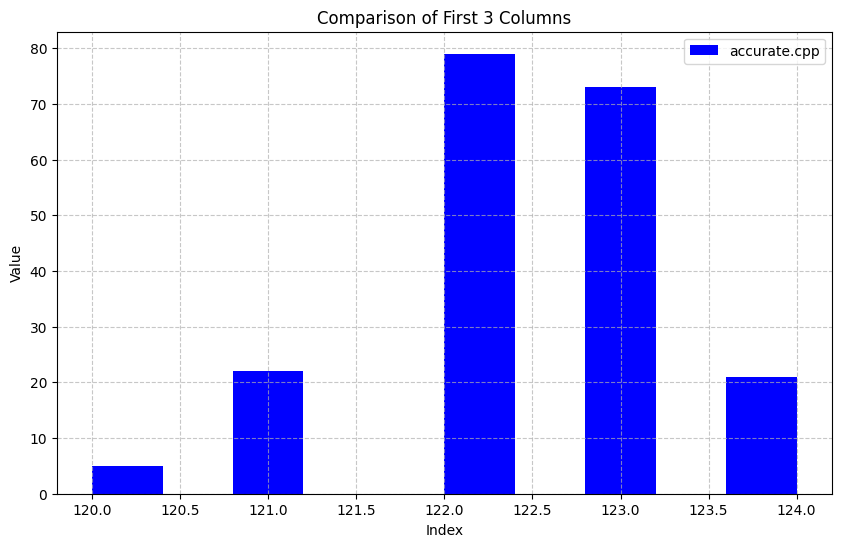

In [13]:

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))

# Plot each column with a different color
plt.hist(df['A1/accurate.cpp'], color='blue', label='accurate.cpp')
# plt.hist(df['A1/accurate_cpu_aff.cpp'], color='red', label='accurate_cpu_aff.cpp')
# plt.hist(df['A1/shared_mem.cpp'], color='green', label='shared_mem.cpp')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Comparison of First 3 Columns')
plt.legend()

# Show grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [14]:
import numpy as np
from scipy import stats

def calculate_lognormal_ci(data, confidence=0.95):
    """
    Calculate the mean and confidence interval of a log-normal distributed data.

    Parameters:
    data (array-like): The data to calculate the mean and confidence interval for.
    confidence (float, optional): The desired confidence level for the interval. Default is 0.95.

    Returns:
    tuple: A tuple containing the mean, lower bound of the confidence interval, and upper bound of the confidence interval.

    """
    
    # Convert to log space
    log_data = np.log(data)

    # Calculate mean and standard error in log space
    n = len(log_data)
    mean_log = np.mean(log_data)
    se_log = stats.sem(log_data)

    # Calculate CI in log space
    ci_log = stats.t.interval(confidence, n-1, mean_log, se_log)

    # Transform back to original scale
    ci = np.exp(ci_log)
    mean = np.exp(mean_log)

    return mean, ci[0], ci[1]

# Calculate CI for each column
results = {}
for column in df.columns:
    mean, ci_lower, ci_upper = calculate_lognormal_ci(df[column])
    results[column] = {
        'mean': mean,
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }

# Convert results to a DataFrame for better visualization
results_df = pl.DataFrame(results).T
results_df.columns = ['Mean', '95% CI Lower', '95% CI Upper']

# Print results
print(results_df)


                                     Mean  95% CI Lower  95% CI Upper
A1/accurate.cpp                122.411635    122.284771    122.538630
A1/accurate_cpu_aff.cpp        239.504309    232.516103    246.702543
A1/shared_mem.cpp              111.973071    111.674080    112.272863
A2/semaphore.cpp               671.073866    642.520571    700.896054
A3_A4/threads.cpp            58380.933972  54368.137449  62689.906465
A3_A4/server_client.cpp      57145.565670  56970.798814  57320.868650
A3_A4/server_client_tcp.cpp  84733.471723  79705.510187  90078.605775
A3_A4/docker                 80187.214142  78836.244311  81561.334741


(np.float64(239.5043087842997), np.float64(232.5161027107513), np.float64(246.70254342600762))


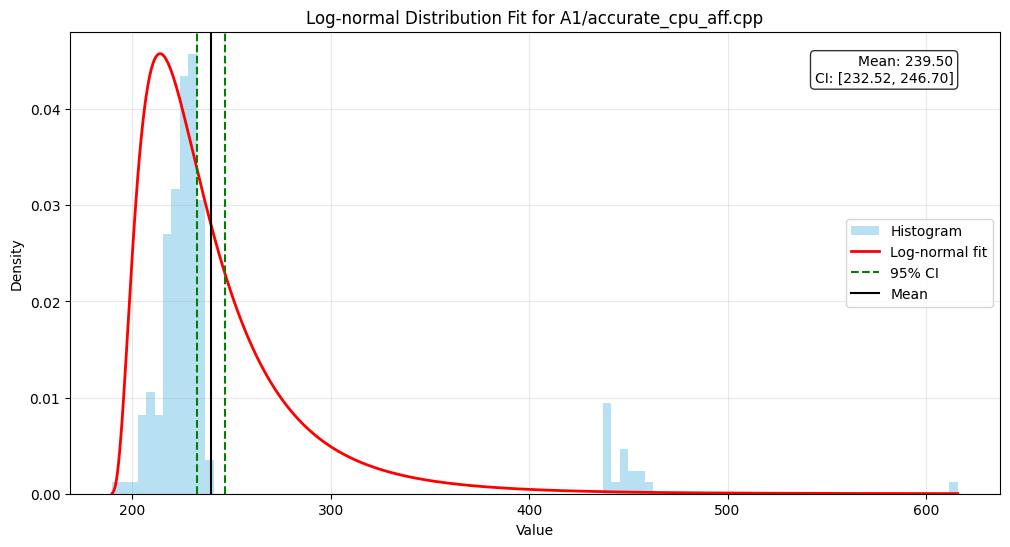

(np.float64(239.5043087842997), np.float64(232.5161027107513), np.float64(246.70254342600762))


In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

CASE = 1

# Get the first column
data = df.iloc[:, CASE]
column_name = df.columns[CASE]

# Calculate log-normal parameters
log_data = np.log(data)
shape, loc, scale = stats.lognorm.fit(data)

# Calculate 95% CI using the percentile method
ci = calculate_lognormal_ci(data)
print(ci)
mean = ci[0]

# Create x values for plotting the distribution
x = np.linspace(min(data), max(data), 1000)
pdf_lognorm = stats.lognorm.pdf(x, shape, loc, scale)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot histogram and get the maximum height for scaling
hist, bins, _ = plt.hist(data, bins=100, density=True, alpha=0.6, color='skyblue', label='Histogram')
max_height = max(hist)

# Scale the PDF to match the histogram height
pdf_lognorm = pdf_lognorm * (max_height / max(pdf_lognorm))

# Plot the scaled fitted log-normal distribution
plt.plot(x, pdf_lognorm, 'r-', lw=2, label='Log-normal fit')

# Add vertical lines for CI
plt.axvline(ci[1], color='g', linestyle='--', label='95% CI')
plt.axvline(ci[2], color='g', linestyle='--')

# Add mean line
plt.axvline(mean, color='k', linestyle='-', label='Mean')

# Customize the plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(f'Log-normal Distribution Fit for {column_name}')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text box with statistics
stats_text = f'Mean: {mean:.2f}\nCI: [{ci[1]:.2f}, {ci[2]:.2f}]'
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()
print(ci)


# Normalverteilung scheint nicht akkurat zu sein (da symmetrisch)

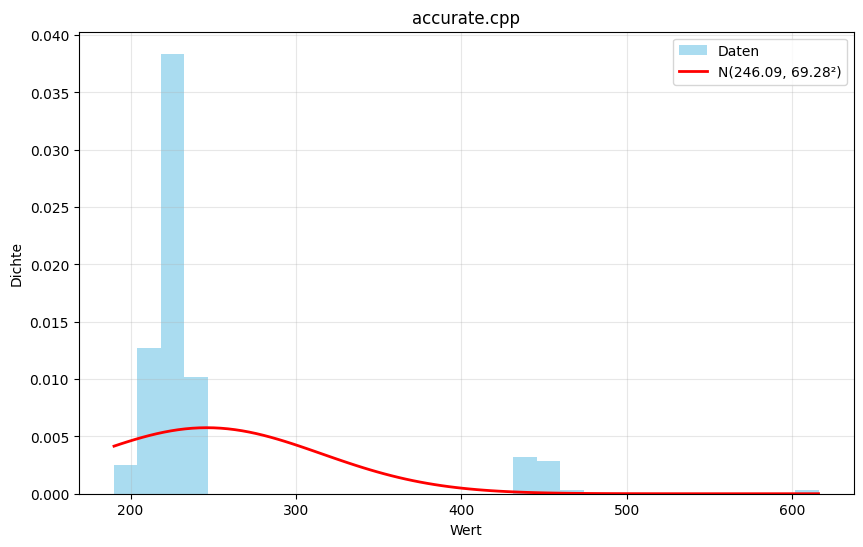

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def plot_histogram_with_normal(data, bins=30, title="Histogramm mit Normalverteilung"):
    """
    Plottet ein Histogramm der Daten und die entsprechende Normalverteilungskurve.

    Parameters:
    data (list or numpy.array): Die Datenpunkte
    bins (int): Anzahl der Bins für das Histogramm
    title (str): Titel des Plots
    """

    # Konvertiere zu numpy array falls nötig
    data = np.array(data)

    # Berechne Mittelwert und Standardabweichung
    mu = np.mean(data)
    sigma = np.std(data)

    # Erstelle den Plot
    plt.figure(figsize=(10, 6))

    # Plotte Histogramm (normiert)
    counts, bins, _ = plt.hist(data, bins=bins, density=True, alpha=0.7, 
                              color='skyblue', label='Daten')

    # Erstelle x-Werte für die Normalverteilungskurve
    x = np.linspace(min(data), max(data), 100)

    # Berechne und plotte die Normalverteilungskurve
    plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, 
             label=f'N({mu:.2f}, {sigma:.2f}²)')

    # Beschriftungen
    plt.title(title)
    plt.xlabel('Wert')
    plt.ylabel('Dichte')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.show()

# Plotte Histogramm mit Normalverteilung für die erste Spalte
plot_histogram_with_normal(df.iloc[:,1], title='accurate.cpp')

# Minimum?

(np.float64(239.5043087842997), np.float64(232.5161027107513), np.float64(246.70254342600762))


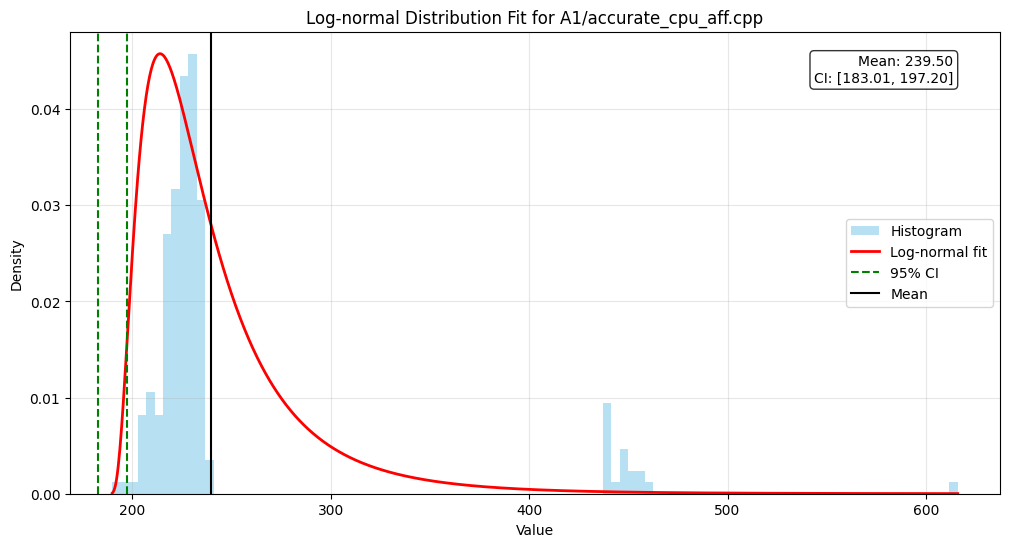

(np.float64(239.5043087842997), np.float64(232.5161027107513), np.float64(246.70254342600762))


In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

CASE = 1

# Get the first column
data = df.iloc[:, CASE]
column_name = df.columns[CASE]

# Calculate log-normal parameters
log_data = np.log(data)
shape, loc, scale = stats.lognorm.fit(data)

# Calculate 95% CI using the percentile method
ci = calculate_lognormal_ci(data)
print(ci)
mean = ci[0]

lower_diff = mean - ci[1]
upper_diff = ci[2] - mean

data_min = min(data)
ci_for_min = [data_min - lower_diff, data_min + upper_diff]

# Create x values for plotting the distribution
x = np.linspace(min(data), max(data), 1000)
pdf_lognorm = stats.lognorm.pdf(x, shape, loc, scale)

# Create the plot
plt.figure(figsize=(12, 6))

# Plot histogram and get the maximum height for scaling
hist, bins, _ = plt.hist(data, bins=100, density=True, alpha=0.6, color='skyblue', label='Histogram')
max_height = max(hist)

# Scale the PDF to match the histogram height
pdf_lognorm = pdf_lognorm * (max_height / max(pdf_lognorm))

# Plot the scaled fitted log-normal distribution
plt.plot(x, pdf_lognorm, 'r-', lw=2, label='Log-normal fit')

# Add vertical lines for CI
plt.axvline(ci_for_min[0], color='g', linestyle='--', label='95% CI')
plt.axvline(ci_for_min[1], color='g', linestyle='--')

# Add mean line
plt.axvline(mean, color='k', linestyle='-', label='Mean')

# Customize the plot
plt.xlabel('Value')
plt.ylabel('Density')
plt.title(f'Log-normal Distribution Fit for {column_name}')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text box with statistics
stats_text = f'Mean: {mean:.2f}\nCI: [{ci_for_min[0]:.2f}, {ci_for_min[1]:.2f}]'
plt.text(0.95, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         horizontalalignment='right',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()
print(ci)
